In [39]:
using CSV, DataFrames, Statistics, Clustering, Plots, Random, Gurobi, JuMP, DataStructures, StatsBase

In [204]:
data_prev = CSV.read("data/pred_Maruipe.csv",DataFrame)
data_opti = CSV.read("data/opti_Maruipe.csv",DataFrame)

data_logistic = CSV.read("data/opti_Maria.csv",DataFrame)
pred_logistic = CSV.read("data/pred_lr.csv",DataFrame)[:, "0"];
pred_logistic_week = Matrix(CSV.read("data/pred_lr_week.csv",DataFrame))
pred_logistic_sms = Matrix(CSV.read("data/pred_lr_sms.csv",DataFrame))

pred_forest = CSV.read("data/y_new.csv", DataFrame)
pred_forest_sms = CSV.read("data/y_sms.csv", DataFrame);

In [41]:
#number booked appointments
na = nrow(data_prev)
#number new appointments
nb = nrow(data_opti)
ntot = na + nb
#number doctors
nd = 15
#penalty added nurse
pen_nurse = 1200
pen_noshow = 600
#previously_booked
s = data_prev.slot .+1 ;

### Model 1 : Only penalize double booking (day)

In [4]:
function optim_add_nurse(p)
    model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=180))
    set_optimizer_attribute(model, "OutputFlag", 0)

    @variable(model, x[1:ntot, 1:50], Bin)
    @variable(model, t[1:50])

    @objective(model, Min, sum(t)*pen_nurse + pen_noshow*sum((1-p[i,j])*x[i,j] for i=1:ntot, j=1:50) )

    @constraint(model, [j=1:50], t[j] >= sum(x[i,j]*p[i,j] for i=1:ntot) - nd) 
    @constraint(model, [j=1:50], t[j] >= 0)

    for i=1:na
        for j=1:50
            if s[i]==j
                @constraint(model, x[i,j] == 1)
            else
                @constraint(model, x[i,j] == 0)
            end
        end
    end

    for i=na+1:ntot
        for j=1:50
            if j in a[i-na,:]
            else
                @constraint(model, x[i,j] == 0)
            end
        end
    end

    @constraint(model, [i=1:ntot], sum(x[i,j] for j=1:50) == 1)


    optimize!(model)
    return objective_value(model), JuMP.value.(x)
end

optim_add_nurse (generic function with 1 method)

In [4]:
a = Matrix(data_opti[:,121:125]);

In [5]:
p_oracle = ones(ntot,50)
for i = 1:na
    for j=1:50
        p_oracle[i,j] = 1 - data_prev.NoShow[i]
    end
end
for i = na+1:ntot
    for j=1:50
        p_oracle[i,j] = 1 - data_opti.NoShow[i-na]
    end
end

In [6]:
o, _ = optim_add_nurse(p_oracle)
o

LoadError: UndefVarError: optim_add_nurse not defined

In [4]:
p_random = rand(ntot, 50);
_, x_r = optim_add_nurse(p_random)
sum([max(sum(x_r[i,j]*p_oracle[i,j] for i=1:ntot) - nd, 0)*pen_nurse + pen_noshow*sum((1-p_oracle[i,j])*x_r[i,j] for i=1:ntot) for j=1:50])

LoadError: UndefVarError: optim_add_nurse not defined

In [8]:
p_no_idea = ones(ntot, 50) .- 0.5;
_, x_ni = optim_add_nurse(p_no_idea)
sum([max(sum(x_ni[i,j]*p_oracle[i,j] for i=1:ntot) - nd, 0)*pen_nurse + pen_noshow*sum((1-p_oracle[i,j])*x_ni[i,j] for i=1:ntot) for j=1:50])

LoadError: UndefVarError: optim_add_nurse not defined

In [42]:
p_logistic = ones(ntot,50)
for i = 1:na
    for j=1:50
        p_logistic[i,j] = 1 - pred_logistic[i]
    end
end
for i = na+1:ntot
    for j=1:50
        p_logistic[i,j] = 1 - pred_logistic[i-na]
    end
end

In [13]:
_, x_log = optim_add_nurse(p_logistic)
sum([max(sum(x_log[i,j]*p_oracle[i,j] for i=1:ntot) - nd, 0)*pen_nurse + pen_noshow*sum((1-p_oracle[i,j])*x_log[i,j] for i=1:ntot) for j=1:50])

Academic license - for non-commercial use only - expires 2022-08-18


349800.0

### Model 2 : Only penalize double booking (week)

In [12]:
a = Matrix(data_opti[:, 111:120]) .+ 1;
p = rand(ntot, 50);

In [13]:
s_m = reshape(counts(s, 50), (10,5));

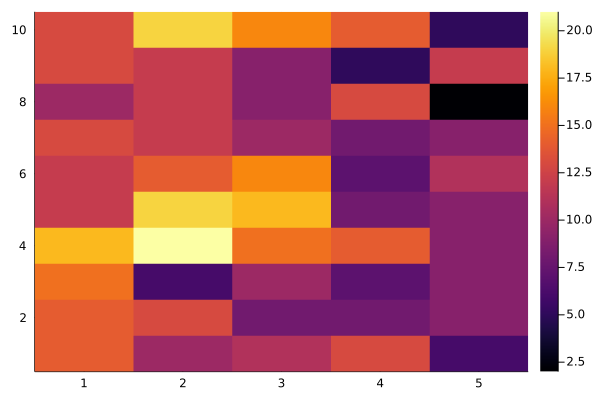

In [14]:
heatmap(s_m)

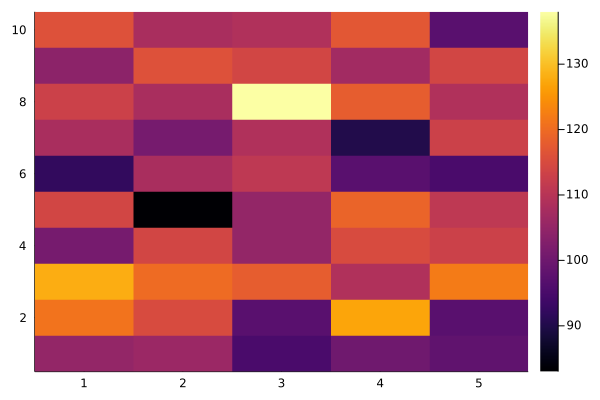

In [15]:
a_m = reshape(counts(a, 50), (10,5))
heatmap(a_m)

In [16]:
_, x = optim_add_nurse(p)

Academic license - for non-commercial use only - expires 2022-08-18


(0.0, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [17]:
schedul = reshape(sum(x[i,:] for i=1:ntot), (10,5))

10×5 Matrix{Float64}:
 36.0  16.0  22.0  18.0  15.0
 37.0  26.0  15.0  22.0  20.0
 33.0  15.0  14.0  12.0  21.0
 33.0  27.0  26.0  21.0  18.0
 34.0  26.0  23.0  23.0  24.0
 25.0  26.0  24.0  17.0  23.0
 31.0  22.0  19.0  16.0  19.0
 26.0  19.0  22.0  23.0  12.0
 22.0  26.0  21.0  15.0  24.0
 29.0  23.0  23.0  26.0   7.0

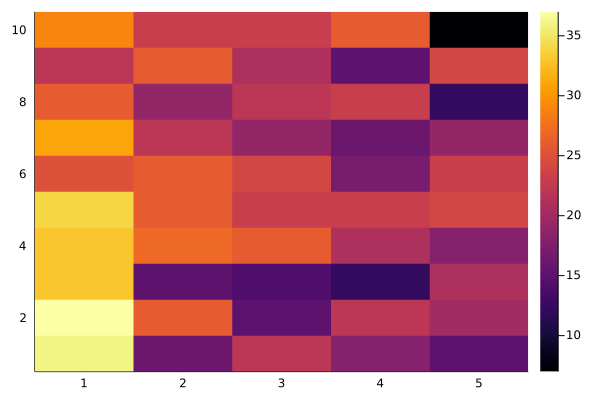

In [18]:
heatmap(schedul)

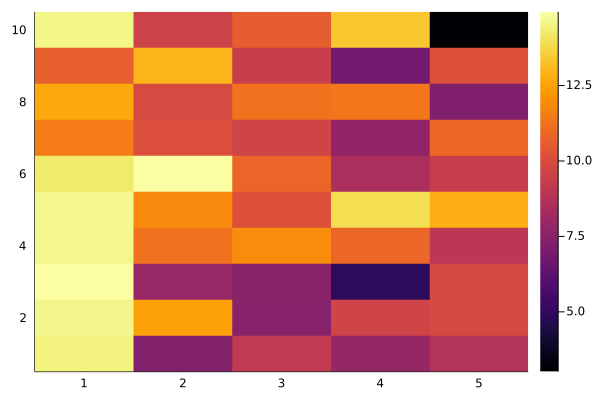

In [19]:
schedule_show = reshape([sum(x[i,j]*p[i,j] for i=1:ntot) for j=1:50], (10,5));
heatmap(schedule_show)

In [20]:
sum([max(sum(x[i,j]*(p[i,j]>0.5) for i=1:ntot) - nd, 0) for j=1:50])

4.0

##### Comparison with random

In [21]:
opti_random = [rand(1:50) for i=1:nb];

In [22]:
x_random = cat(s, opti_random, dims=1);

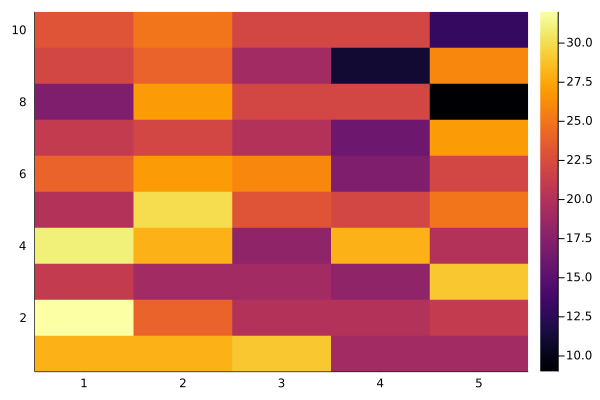

In [23]:
x_random_m = reshape(counts(x_random, 50), (10,5))
heatmap(x_random_m)

In [24]:
x_r = zeros(ntot, 50)
for i = 1:ntot
    for j = 1:50
        if x_random[i]==j
            x_r[i,j]=1
        end
    end
end

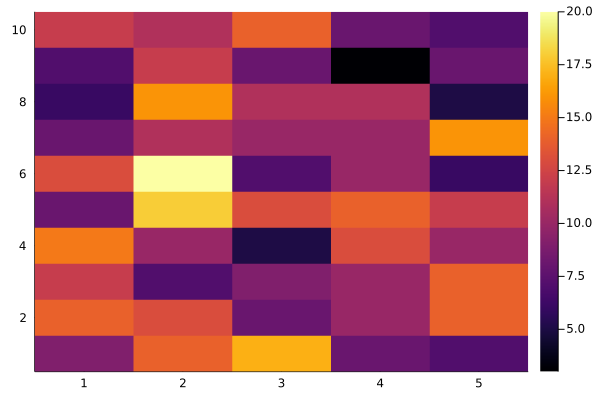

In [25]:
random_show = reshape([sum(x_r[i,j]*(p[i,j]>0.5) for i=1:ntot) for j=1:50], (10,5));
heatmap(random_show)

In [26]:
sum([max(sum(x_r[i,j]*(p[i,j]>0.5) for i=1:ntot) - nd, 0) for j=1:50])

12.0

##### Comparison with model logistic regression

In [6]:
p_logistic = zeros(ntot,50)
for i = 1:na
    for j=1:50
        p_logistic[i,j] = 1 - pred_logistic[i]
    end
end
for i = na+1:ntot
    for j=1:length(a[1,:])
        p_logistic[i,a[i-na,j]] = 1 - pred_logistic_week[5*(i-na-1) + j]
    end
end

LoadError: UndefVarError: a not defined

In [28]:
_, x = optim_add_nurse(p_logistic)

Academic license - for non-commercial use only - expires 2022-08-18


(661.6213513165654, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 -0.0])

In [29]:
sum([max(sum(x[i,j]*(p_logistic[i,j]>0.5) for i=1:ntot) - nd, 0) for j=1:50])

366.0

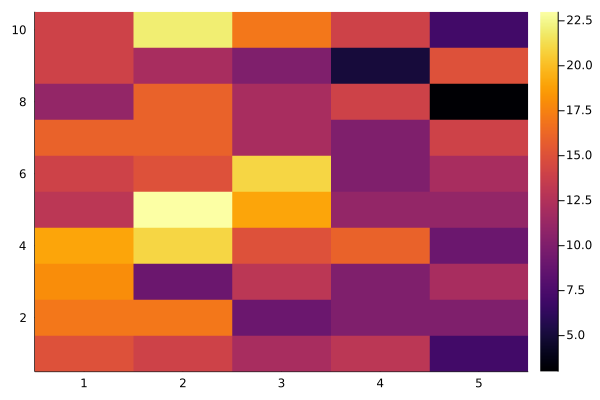

In [30]:
logistic_show = reshape([sum(x_r[i,j]*(p_logistic[i,j]>0.5) for i=1:ntot) for j=1:50], (10,5));
heatmap(logistic_show)

### Model 3 : SMS or not (day)

In [31]:
function optim_add_nurse_SMS(p_sms, p_nosms)
model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=180))
set_optimizer_attribute(model, "OutputFlag", 0)

@variable(model, x[1:ntot, 1:50], Bin) #bin
@variable(model, t[1:50])
@variable(model, r[1:ntot, 1:50], Bin) #send SMS or not #bin
@variable(model, z[1:ntot, 1:50], Bin) # x & s (linearize) #binary

@objective(model, Min, sum(t)*pen_nurse + sum(z)*pen_sms + pen_noshow*sum(sum((1-p_sms[i,j])*r[i,j]+(1-p_nosms[i,j])*(1-r[i,j]) for i=1:ntot) for j=1:50))

@constraint(model, [j=1:50], t[j] >= sum(z[i,j]*p_sms[i,j] + (x[i,j]-z[i,j])*p_nosms[i,j]  for i=1:ntot) - nd) 
@constraint(model, [j=1:50], t[j] >= 0)
    
@constraint(model, [i=1:ntot, j=1:50], z[i,j] <= (r[i,j] + x[i,j])/2)
@constraint(model, [i=1:ntot, j=1:50], z[i,j] >= r[i,j] + x[i,j] - 1)

for i=1:na
    for j=1:50
        if s[i]==j
            @constraint(model, x[i,j] == 1)
        else
            @constraint(model, x[i,j] == 0)
        end
    end
end

for i=na+1:ntot
    for j=1:50
        if j in a[i-na,:]
        else
            @constraint(model, x[i,j] == 0)
        end
    end
end

@constraint(model, [i=1:ntot], sum(x[i,j] for j=1:50) == 1)
        

optimize!(model)
return objective_value(model), JuMP.value.(x), JuMP.value.(z)
end

optim_add_nurse_SMS (generic function with 1 method)

In [32]:
pen_nurse = 5
pen_noshow = 5
pen_sms = 0.00001;

In [84]:
a = Matrix(data_opti[:,121:125])

p_sms, p_nosms = pred_logistic_sms[:,1], pred_logistic_sms[:,2]

p_sms_m = ones(ntot,50)
for i = 1:na
    for j=1:50
        p_sms_m[i,j] = 1 - p_sms[i]
    end
end
for i = na+1:ntot
    for j=1:50
        p_sms_m[i,j] = 1 - p_sms[i-na]
    end
end

p_nosms_m = ones(ntot,50)
for i = 1:na
    for j=1:50
        p_nosms_m[i,j] = 1 - p_nosms[i]
    end
end
for i = na+1:ntot
    for j=1:50
        p_nosms_m[i,j] = 1 - p_nosms[i-na]
    end
end

In [34]:
_, x, z = optim_add_nurse_SMS(p_sms_m, p_nosms_m)

Academic license - for non-commercial use only - expires 2022-08-18


(78225.83600872033, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [35]:
sum(z)

201.0

### Model 4 : no holes in schedule (day)

In [70]:
function optim_add_nurse_hole(p)
    model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=180))
    set_optimizer_attribute(model, "OutputFlag", 0)

    @variable(model, x[1:ntot, 1:50], Bin)
    @variable(model, t[1:50])
    @variable(model, u[1:50])

    @objective(model, Min, sum(t)*pen_nurse + sum(u)*pen_hole)

    @constraint(model, [j=1:50], t[j] >= sum(x[i,j]*p[i,j] for i=1:ntot) - nd) 
    @constraint(model, [j=1:50], t[j] >= 0)

    for d=1:5
        for j=2:9
            h = (d-1)*10 + j
            @constraint(model, u[h] >= 0)
            @constraint(model, u[h] >= - sum(p[i,h]*x[i,h] for i=1:ntot) + sum(p[i,h-1]*x[i,h-1] for i=1:ntot))
            for k=1:10-j
                @constraint(model, u[h] >= - sum(p[i,h]*x[i,h] for i=1:ntot) + sum(p[i,h+k]*x[i,h+k] for i=1:ntot))
            end
        end
            @constraint(model, u[(d-1)*10 + 10] == 0)
            @constraint(model, u[(d-1)*10 + 1] == 0)
    end
    
    for i=1:na
        for j=1:50
            if s[i]==j
                @constraint(model, x[i,j] == 1)
            else
                @constraint(model, x[i,j] == 0)
            end
        end
    end

    for i=na+1:ntot
        for j=1:50
            if j in a[i-na,:]
            else
                @constraint(model, x[i,j] == 0)
            end
        end
    end

    @constraint(model, [i=1:ntot], sum(x[i,j] for j=1:50) == 1)


    optimize!(model)
    return objective_value(model), JuMP.value.(x)
end

optim_add_nurse_hole (generic function with 1 method)

In [71]:
pen_nurse = 5
pen_noshow = 5
pen_hole = 5
pen_sms = 0.00001;

In [72]:
_, x = optim_add_nurse_hole(p_logistic)

Academic license - for non-commercial use only - expires 2022-08-18


(81.55719253204184, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [74]:
sum([max(sum(x[i,j]*p_oracle[i,j] for i=1:ntot) - nd, 0)*pen_nurse for j=1:50])

1355.0

In [75]:
schedul = reshape(sum(x[i,:] for i=1:ntot), (10,5))

10×5 Matrix{Float64}:
 15.0  10.0  11.0  13.0   6.0
 18.0  20.0  18.0  13.0  13.0
 19.0  14.0  19.0  14.0  13.0
 20.0  23.0  20.0  18.0  16.0
 21.0  20.0  23.0  21.0  21.0
 25.0  25.0  31.0  22.0  20.0
 36.0  21.0  32.0  27.0  21.0
 32.0  37.0  33.0  25.0  32.0
 43.0  36.0  44.0  48.0  40.0
 13.0  19.0  17.0  14.0   5.0

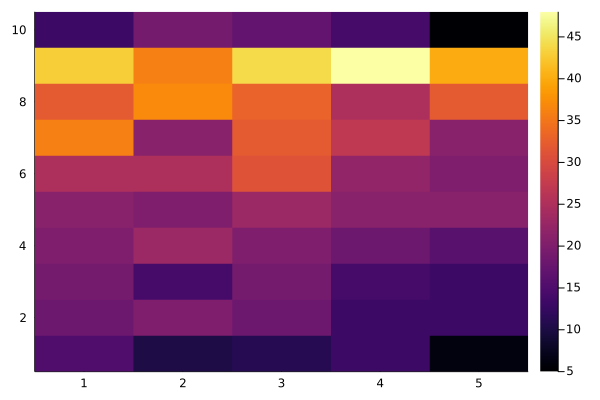

In [76]:
heatmap(schedul)

### Model 5 : maximize profit (penalize overbooking)

In [16]:
a = Matrix(data_opti[:,121:125]) .+ 1
p_oracle = ones(ntot,50)
for i = 1:na
    for j=1:50
        p_oracle[i,j] = 1 - data_prev.NoShow[i]
    end
end
for i = na+1:ntot
    for j=1:50
        p_oracle[i,j] = 1 - data_opti.NoShow[i-na]
    end
end;

In [213]:
p_forest = zeros(ntot,50)
for i = 1:na
    for j=1:50
        p_forest[i,j] = 1 - pred_forest[:,1][i]
    end
end
for i = na+1:ntot
    for j=1:length(a[1,:])
        p_forest[i,a[i-na,j]] = 1 - pred_forest[:,1][5*(i-na-1) + j]
    end
end

In [241]:
pred_forest

,1
,Float64
1,0.331609
2,0.343235
3,0.312895
4,0.382216
5,0.26052
6,0.405856
7,0.317075
8,0.338947
9,0.396235


In [239]:
p_sms, p_nosms = pred_forest_sms[:,1], pred_forest_sms[:,2]

p_sms_m = ones(ntot,50)
for i = 1:na
    for j=1:50
        p_sms_m[i,j] = 1 - p_sms[i]
    end
end
for i = na+1:ntot
    for j=1:50
        p_sms_m[i,j] = 1 - p_sms[i-na]
    end
end

p_nosms_m = ones(ntot,50)
for i = 1:na
    for j=1:50
        p_nosms_m[i,j] = 1 - p_nosms[i]
    end
end
for i = na+1:ntot
    for j=1:50
        p_nosms_m[i,j] = 1 - p_nosms[i-na]
    end
end

In [217]:
mean(data_opti.NoShow)

0.09615384615384616

In [218]:
nd = 8 #number doctors
ph = 600 #profit hour if patient shows up
ch = 90 #cost per hour booked
cd = 600

600

In [22]:
function optim_profit_double(p)
    model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=180))
    set_optimizer_attribute(model, "OutputFlag", 0)

    @variable(model, x[1:ntot, 1:50, 1:nd], Bin)
    @variable(model, t[1:50, 1:nd])

    @objective(model, Min, -ph*sum(x[i,j,k]*p[i,j] for i=1:ntot, j=1:50, k=1:nd) + cd*sum(t[j,k] for j=1:50, k=1:nd))
    #pb linear penalization : same to have 3 appointments in 1 hour than 2 slots double booked
    
    @constraint(model, [j=1:50, k=1:nd], t[j,k] >= 0)
    @constraint(model, [j=1:50, k=1:nd], t[j,k] >= sum(p[i,j]*x[i,j,k] for i=1:ntot) -1)
    @constraint(model, [j=1:50, k=1:nd], sum(x[i,j,k] for i=1:ntot) <= 2)
    
    @constraint(model, [k=1:nd], sum(x[i,j,k] for i=1:ntot, j=1:50) <= 70)
    
    for i=1:na
        for j=1:50
            if s[i]==j
                @constraint(model, sum(x[i,j,:]) == 1)
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    for i=na+1:ntot
        for j=1:50
            if j in a[i-na,:]
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    @constraint(model, [i=1:ntot], sum(x[i,j,k] for j=1:50, k=1:nd) == 1)

    optimize!(model)
    return objective_value(model), JuMP.value.(x), JuMP.value.(t)
end

optim_profit_double (generic function with 1 method)

In [23]:
_, x, t = optim_profit_double(p_oracle)

Academic license - for non-commercial use only - expires 2022-08-18


(-178800.0, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0])

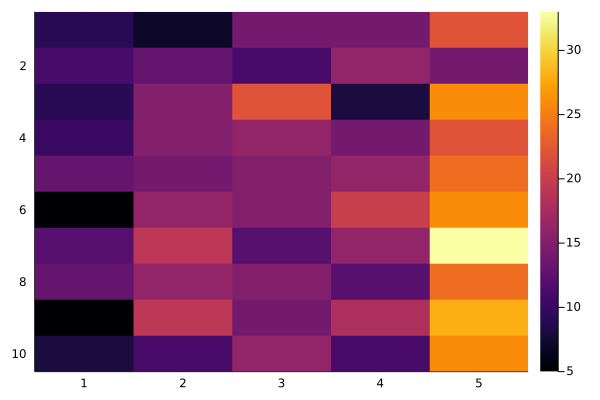

In [24]:
a_m = reshape(counts(a, 50), (10,5))
heatmap(a_m, yflip = true)

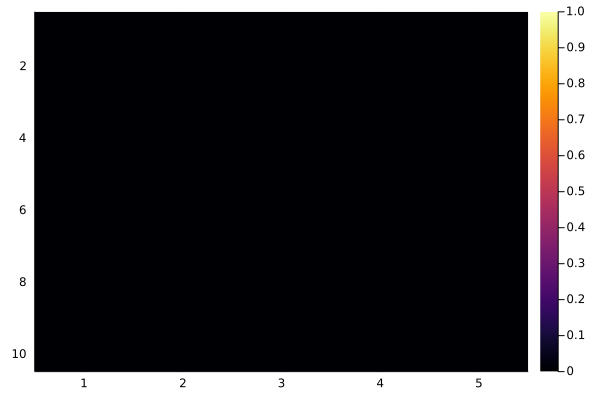

In [25]:
x_h = reshape(sum(x[i,:, j] for i=1:ntot, j=1:nd).>20, (10,5))
heatmap(x_h, yflip = true)

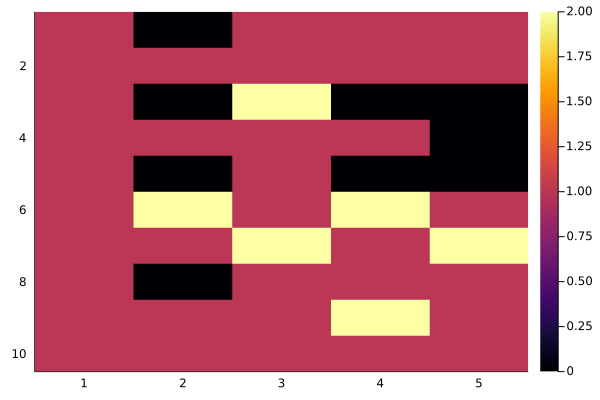

In [26]:
x_h = reshape(sum(x[i,:, 2] for i=1:ntot), (10,5))
heatmap(x_h, yflip = true, clim=(0,2))

In [129]:
_, xl, tl = optim_profit_double(p_logistic)

Academic license - for non-commercial use only - expires 2022-08-18


(-247852.84863101077, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

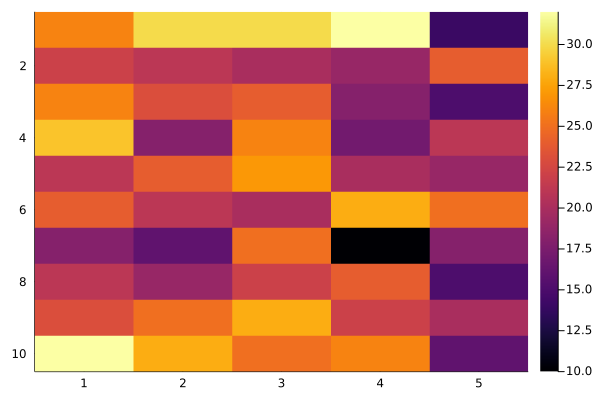

In [130]:
xl_h = reshape(sum(xl[i,:, j] for i=1:ntot, j=1:nd), (10,5))
heatmap(xl_h, yflip = true)

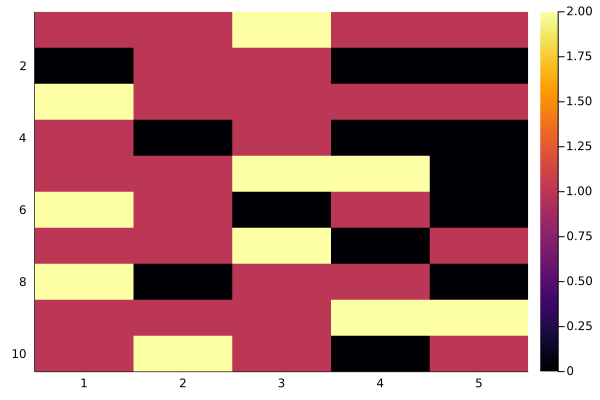

In [131]:
xl_h = reshape(sum(xl[i,:, 2] for i=1:ntot), (10,5))
heatmap(xl_h, yflip = true, clim = (0,2))

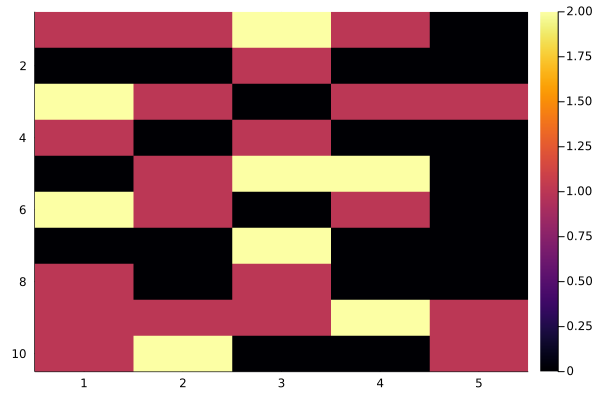

In [132]:
xl_h = reshape([sum(xl[i,j,2]*p_oracle[i,j] for i=1:ntot) for j=1:50], (10,5))
heatmap(xl_h, yflip = true, clim = (0,2))

In [133]:
-ph*sum(xl[i,j,k]*p_oracle[i,j] for i=1:ntot, j=1:50, k=1:nd) + cd*sum(max(sum(p_oracle[i,j]*xl[i,j,k] for i=1:ntot)-1, 0) for j=1:50, k=1:nd)

-429000.0

In [6]:
p_no_idea = ones(ntot, 50) .- 0.5;

In [135]:
_, xn, tn = optim_profit_double(p_no_idea);

Academic license - for non-commercial use only - expires 2022-08-18


In [136]:
-ph*sum(xn[i,j,k]*p_oracle[i,j] for i=1:ntot, j=1:50, k=1:nd) + cd*sum(max(sum(p_oracle[i,j]*xn[i,j,k] for i=1:ntot)-1, 0) for j=1:50, k=1:nd)

-421200.0

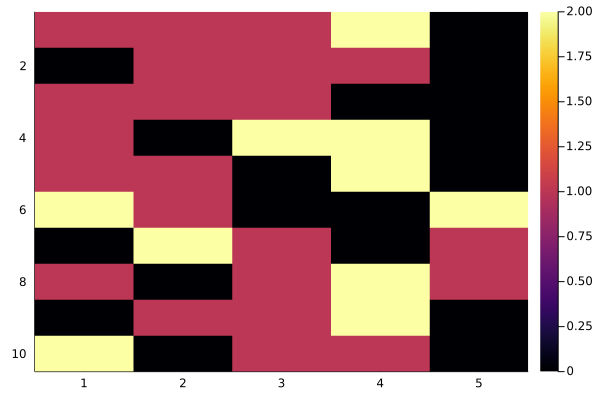

In [137]:
xn_h = reshape(sum(xn[i,:, 2] for i=1:ntot), (10,5))
heatmap(xn_h, yflip = true, clim = (0,2))

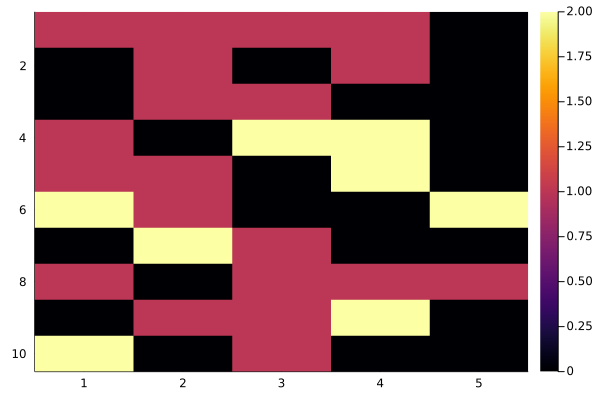

In [138]:
xn_h = reshape([sum(xn[i,j,2]*p_oracle[i,j] for i=1:ntot) for j=1:50], (10,5))
heatmap(xn_h, yflip = true, clim = (0,2))

### Model 6 : max profit under paying assumption

In [46]:
function optim_profit_hole2(p)
    model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=180))
    set_optimizer_attribute(model, "OutputFlag", 0)

    @variable(model, x[1:ntot, 1:50, 1:nd], Bin)
    @variable(model, u[1:nd, 1:5, 1:10], Bin)
    @variable(model, v[1:nd, 1:5, 1:10], Bin)
    @variable(model, w[1:nd, 1:5, 1:10], Bin)

    @objective(model, Min, -ph*sum(x[i,j,k]*p[i,j] for i=1:ntot, j=1:50, k=1:nd) + ch*sum(w))
    
    for k=1:nd
        for l=1:5
            for i=1:10
                for j=i+1:10
                    @constraint(model, u[k,l,i] <= u[k,l,j])
                    @constraint(model, v[k,l,i] >= v[k,l,j])
                end
            end
        end
    end
    @constraint(model, [k=1:nd, l=1:5, j=1:10], u[k,l,j] >= sum(x[i,10*(l-1)+j,k] for i=1:ntot)/ntot)
    @constraint(model, [k=1:nd, l=1:5, j=1:10], v[k,l,j] >= sum(x[i,10*(l-1)+j,k] for i=1:ntot)/ntot)
    
    @constraint(model, [k=1:nd, l=1:5, j=1:10], w[k,l,j] >= u[k,l,j] + v[k,l,j] - 1)
    @constraint(model, [k=1:nd, l=1:5, j=1:10], w[k,l,j] <= (u[k,l,j] + v[k,l,j])/2)
    
    @constraint(model, [j=1:50, k=1:nd], sum(x[i,j,k] for i=1:ntot) <= 2)
    @constraint(model, [k=1:nd], sum(x[i,j,k] for i=1:ntot, j=1:50) <= 70)
    
    for i=1:na
        for j=1:50
            if s[i]==j
                @constraint(model, sum(x[i,j,:]) == 1)
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    for i=na+1:ntot
        for j=1:50
            if j in a[i-na,:]
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    @constraint(model, [i=1:ntot], sum(x[i,j,k] for j=1:50, k=1:nd) == 1)

    optimize!(model)
    return objective_value(model), JuMP.value.(x), JuMP.value.(w)
end

optim_profit_hole2 (generic function with 1 method)

In [28]:
_, x, w = optim_profit_hole2(p_oracle);

Academic license - for non-commercial use only - expires 2022-08-18


(-162540.0, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [1.0 1.0 … -0.0 -0.0; 1.0 1.0 … 1.0 -0.0; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0]

[1.0 1.0 … -0.0 1.0; 1.0 1.0 … 1.0 -0.0; … ; -0.0 0.0 … -0.0 -0.0; -0.0 1.0 … -0.0 -0.0]

[1.0 1.0 … -0.0 1.0; 1.0 1.0 … 1.0 -0.0; … ; -0.0 0.0 … -0.0 -0.0; 1.0 1.0 … -0.0 1.0]

[1.0 1.0 … -0.0 1.0; 1.0 1.0 … 1.0 -0.0; … ; -0.0 1.0 … -0.0 

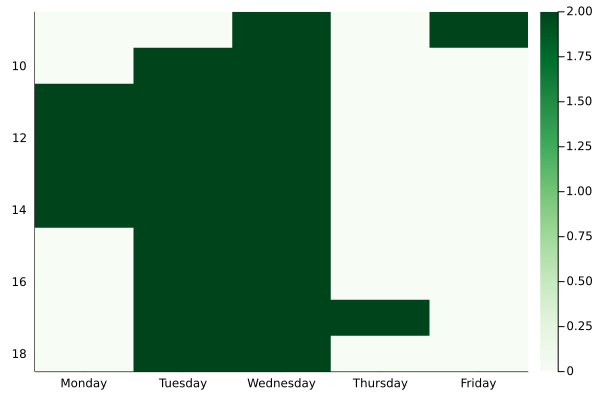

In [61]:
x_h = reshape(sum(x[i,:, 3] for i=1:ntot), (10,5))
heatmap(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], [9:18], x_h, yflip = true, c=:Greens_9)

In [47]:
olog, xlog, wlog = optim_profit_hole2(p_logistic);

Academic license - for non-commercial use only - expires 2022-08-18


In [49]:
-ph*sum(xlog[i,j,k]*p_oracle[i,j] for i=1:ntot, j=1:50, k=1:nd) + ch*sum(wlog)

-162540.0

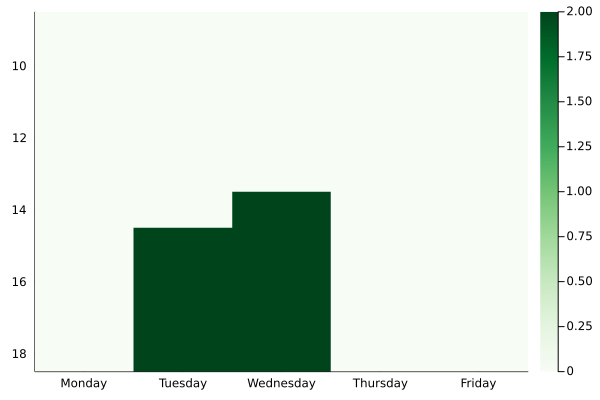

In [71]:
xlog_h = reshape(sum(xlog[i,:, 3] for i=1:ntot), (10,5))
heatmap(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], [9:18], xlog_h, yflip = true, c=:Greens_9)

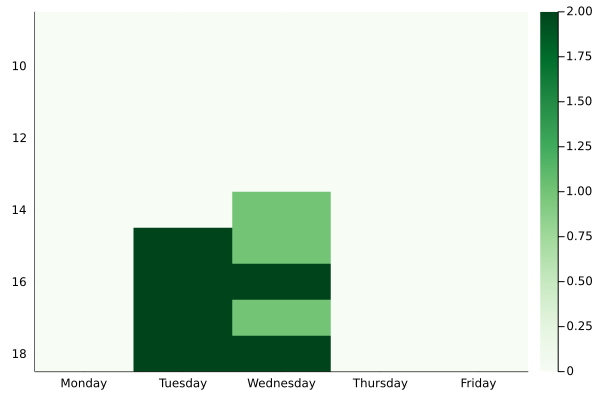

In [72]:
xlog_h = reshape([sum(xlog[i,j, 3]*p_oracle[i,j] for i=1:ntot) for j=1:50], (10,5))
heatmap(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], [9:18], xlog_h, yflip = true, c=:Greens_9)

### Model 7 : include sms

In [219]:
cs = 0.03 #cost sms

0.03

In [220]:
function optim_profit_sms(p_sms, p_nosms)
    model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=180))
    set_optimizer_attribute(model, "OutputFlag", 0)

    @variable(model, x[1:ntot, 1:50, 1:nd], Bin)
    @variable(model, r[1:ntot, 1:50], Bin)
    @variable(model, z[1:ntot, 1:50], Bin)

    @objective(model, Min, -ph*sum(z[i,j]*p_sms[i,j] + p_nosms[i,j]*(sum(x[i,j,k] for k=1:nd)- z[i,j]) for i=1:ntot, j=1:50) + cs*sum(z))

    @constraint(model, [i=1:ntot, j=1:50], z[i,j] <= (sum(x[i,j,k] for k=1:nd) + r[i,j])/2)
    @constraint(model, [i=1:ntot, j=1:50], z[i,j] >= sum(x[i,j,k] for k=1:nd) + r[i,j] - 1)
    
    for i=1:na
        for j=1:50
            if s[i]==j
                @constraint(model, sum(x[i,j,:]) == 1)
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    for i=na+1:ntot
        for j=1:50
            if j in a[i-na,:]
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    @constraint(model, [i=1:ntot], sum(x[i,j,k] for j=1:50, k=1:nd) == 1)

    optimize!(model)
    return objective_value(model), JuMP.value.(x), JuMP.value.(z)
end

optim_profit_sms (generic function with 1 method)

In [221]:
_, xlog, z_log = optim_profit_sms(p_sms_m, p_nosms_m)

Academic license - for non-commercial use only - expires 2022-08-18


(-152251.71183652387, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [222]:
sum(z_log)

194.0

In [223]:
smssent = findall(x -> x==1, z_log)
counts([smssent[i][2] for i = 1:length(smssent)], 1:50)

50-element Vector{Int64}:
 2
 2
 2
 2
 3
 3
 3
 0
 2
 3
 2
 7
 4
 ⋮
 5
 3
 2
 6
 6
 5
 6
 8
 3
 3
 5
 1

In [224]:
l_time = zeros(0)

for i=1:length(smssent)
    idx = smssent[i][1]
    if idx <=228
        append!(l_time, data_prev.AwaitingTime[idx,:])
    else
        append!(l_time, data_opti.AwaitingTime[idx-228,:])
    end
end

In [225]:
maximum(l_time)

179.0

In [226]:
minimum(l_time)

0.0

In [227]:
counts(Int.(l_time), 1:179)

179-element Vector{Int64}:
 11
 14
  4
  0
  1
  7
  6
  2
  3
  1
  1
  0
  3
  ⋮
  0
  0
  0
  0
  0
  0
  0
  0
  3
  0
  0
  2

In [117]:
mean(l_time)

30.50485436893204

In [118]:
(sum(data_prev.AwaitingTime) + sum(data_opti.AwaitingTime))/ntot

20.096354166666668

In [233]:
data_prev.AwaitingTime[10]

40

In [236]:
p_sms[10] - p_nosms[10]

0.0032360690441642914

In [238]:
p_sms

1117-element Vector{Float64}:
 0.3316089068558304
 0.3432345709573411
 0.3128950049318772
 0.3822162963929457
 0.26052019189176095
 0.40585599675159595
 0.3170752487939263
 0.3389471331232569
 0.39623450212074784
 0.34623886476422405
 0.3622971308228942
 0.3015346097027198
 0.44779400877547876
 ⋮
 0.13040761773277879
 0.12374232399578615
 0.20451059165981647
 0.2687184611254317
 0.09557580480201605
 0.16501197934345313
 0.11735875714233303
 0.18919639462611842
 0.12906804309239256
 0.1721693228221392
 0.17450661273796778
 0.1652485349364658

In [237]:
plot(data_prev.AwaitingTime, p_sms - p_nosms)

BoundsError: BoundsError: attempt to access 228-element Vector{Float64} at index [1:1117]

In [235]:
p_nosms[10]

0.34300279572005976

In [127]:
counts(vcat(data_prev.AwaitingTime, data_opti.AwaitingTime), 1:179)

179-element Vector{Int64}:
 20
 24
  9
  2
  2
 16
 12
  3
  3
  2
  3
  2
  5
  ⋮
  0
  0
  0
  0
  0
  0
  0
  0
  6
  0
  0
  4

### Model 8 : all combined (day)

In [175]:
function optim_profit_combined(p_sms, p_nosms)
    model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=120))
    set_optimizer_attribute(model, "OutputFlag", 0)

    @variable(model, x[1:ntot, 1:50, 1:nd], Bin)
    @variable(model, t[1:50, 1:nd])
    @variable(model, u[1:nd, 1:5, 1:10], Bin)
    @variable(model, v[1:nd, 1:5, 1:10], Bin)
    @variable(model, w[1:nd, 1:5, 1:10], Bin)
    @variable(model, r[1:ntot, 1:50], Bin)
    @variable(model, z[1:ntot, 1:50, 1:nd], Bin)

    @objective(model, Min, -ph*sum(sum(z[i,j,k] for k=1:nd)*p_sms[i,j] + p_nosms[i,j]*sum(x[i,j,k] - z[i,j,k] for k=1:nd) for i=1:ntot, j=1:50) + cd*sum(t[j,k] for j=1:50, k=1:nd) + ch*sum(w) + cs*sum(z))
    
    #@objective(model, Min, -ph*sum(p_nosms[i,j]*(sum(x[i,j,k] - z[i,j,k] for k=1:nd))  for i=1:ntot, j=1:50))
        #cd*sum(t[j,k] for j=1:50, k=1:nd) + ch*sum(w) + cs*sum(z))
    
    @constraint(model, [j=1:50, k=1:nd], sum(x[i,j,k] for i=1:ntot) <= 2)
    @constraint(model, [k=1:nd], sum(x[i,j,k] for i=1:ntot, j=1:50) <= 70)
    
    #Linearization model double booking
    @constraint(model, [j=1:50, k=1:nd], t[j,k] >= 0)
    @constraint(model, [j=1:50, k=1:nd], t[j,k] >= sum(z[i,j,k]*p_sms[i,j] + p_nosms[i,j]*(x[i,j,k] - z[i,j,k]) for i=1:ntot) -1)
    
    #Linearization model hole
    for k=1:nd
        for l=1:5
            for i=1:10
                for j=i+1:10
                    @constraint(model, u[k,l,i] <= u[k,l,j])
                    @constraint(model, v[k,l,i] >= v[k,l,j])
                end
            end
        end
    end
    @constraint(model, [k=1:nd, l=1:5, j=1:10], u[k,l,j] >= sum(x[i,10*(l-1)+j,k] for i=1:ntot)/ntot)
    @constraint(model, [k=1:nd, l=1:5, j=1:10], v[k,l,j] >= sum(x[i,10*(l-1)+j,k] for i=1:ntot)/ntot)
    
    @constraint(model, [k=1:nd, l=1:5, j=1:10], w[k,l,j] >= u[k,l,j] + v[k,l,j] - 1)
    @constraint(model, [k=1:nd, l=1:5, j=1:10], w[k,l,j] <= (u[k,l,j] + v[k,l,j])/2)
    
    #Linearization model sms
    @constraint(model, [i=1:ntot, j=1:50, k=1:nd], z[i,j,k] <= (x[i,j,k] + r[i,j])/2)
    @constraint(model, [i=1:ntot, j=1:50, k=1:nd], z[i,j,k] >= x[i,j,k] + r[i,j] - 1)
    
    #Other constraints    
    for i=1:na
        for j=1:50
            if s[i]==j
                @constraint(model, sum(x[i,j,:]) == 1)
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    for i=na+1:ntot
        for j=1:50
            if j in a[i-na,:]
            else
                @constraint(model, sum(x[i,j,:]) == 0)
            end
        end
    end

    @constraint(model, [i=1:ntot], sum(x[i,j,k] for j=1:50, k=1:nd) == 1)

    optimize!(model)
    return objective_value(model), JuMP.value.(x), JuMP.value.(t), JuMP.value.(w), JuMP.value.(z)
end

optim_profit_combined (generic function with 2 methods)

In [176]:
o, x, t, w, z = optim_profit_combined(p_sms_m, p_nosms_m)

Academic license - for non-commercial use only - expires 2022-08-18


(-139677.33034194235, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 -0.0; -0.0 0.0 … 0.11135405158121081 -0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0; … ; 1.0 1.0 … -0.0 -0.0; 1.0 0.0 … -0.0 -0.0]

[1.0 -0.0 … -0.0 -0.0; -0.0 1.0 … 1.0 -0.0; … ; 1.0 -0.0 … -0.0 0.0; 1.0 1.0 … -0.0 -0.0]

[1.0 -0.0 … -0.0 -0.0; 1.0 1.0 … 1.0 -0.0; … ; 1.0 -0.0 … -0.0 -0.0; 1.0 0.0 … -0.0 -0.0]

[1.0 1.0 … 1.0 -0.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 -0.0 … -0.0 1.0; 1.0 0.0 … -0.0 -0.0]

[1.0 1.0 … 1.0 -0.

In [177]:
-ph*sum(sum(z[i,j,k] for k=1:nd)*p_oracle[i,j] + p_oracle[i,j]*sum(x[i,j,k] - z[i,j,k] for k=1:nd) for i=1:ntot, j=1:50) + cd*sum(max(sum(z[i,j,k]*p_oracle[i,j] + p_oracle[i,j]*(x[i,j,k] - z[i,j,k]) for i=1:ntot) -1, 0) for j=1:50, k=1:nd) + ch*sum(w) + cs*sum(z)

-137904.03

In [178]:
p_sms_05 = ones(ntot,50)*0.5
p_nosms_05 = ones(ntot,50)*0.5;

In [179]:
or, xr, tr, wr, zr = optim_profit_combined(p_sms_05, p_nosms_05)

Academic license - for non-commercial use only - expires 2022-08-18


(-97740.0, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 -0.0 … 0.0 -0.0; -0.0 -0.0 … -0.0 -0.0; … ; -0.0 1.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0]

[1.0 1.0 … 0.0 -0.0; -0.0 1.0 … -0.0 -0.0; … ; 0.0 0.0 … -0.0 1.0; -0.0 -0.0 … 0.0 -0.0]

[1.0 1.0 … 0.0 -0.0; -0.0 1.0 … -0.0 1.0; … ; 1.0 0.0 … -0.0 1.0; -0.0 -0.0 … 0.0 -0.0]

[1.0 1.0 … 1.0 -0.0; -0.0 1.0 … -0.0 1.0; … ; 1.0 0.0 … -0.0 1.0; -0.0 -0.0 … 1.0 -0.0]

[1.0 -0.0 … 1.0 -0.0; 1.0 1.0 … -0.0 1.0; … ; 1

In [180]:
-ph*sum(sum(zr[i,j,k] for k=1:nd)*p_oracle[i,j] + p_oracle[i,j]*sum(xr[i,j,k] - zr[i,j,k] for k=1:nd) for i=1:ntot, j=1:50) + cd*sum(max(sum(zr[i,j,k]*p_oracle[i,j] + p_oracle[i,j]*(xr[i,j,k] - zr[i,j,k]) for i=1:ntot) -1, 0) for j=1:50, k=1:nd) + ch*sum(wr) + cs*sum(zr)

-91740.0

In [181]:
nd

15

In [183]:
p_sms

384-element Vector{Float64}:
 0.11166332493124764
 0.15482952560890403
 0.1501798233211669
 0.14641614617979665
 0.11499446698893336
 0.21504904351634593
 0.15966046266733722
 0.19576870994240153
 0.39710546156132076
 0.41170831726609897
 0.3424386194415725
 0.31937504967516966
 0.32840653077955945
 ⋮
 0.06345972942144991
 0.05307352514595531
 0.06518597439545575
 0.06662527807284062
 0.10645852271719178
 0.05103042638636885
 0.07721678231976185
 0.05812433254514225
 0.0799095052458994
 0.07007630887360225
 0.11527614572784518
 0.0847972002965112

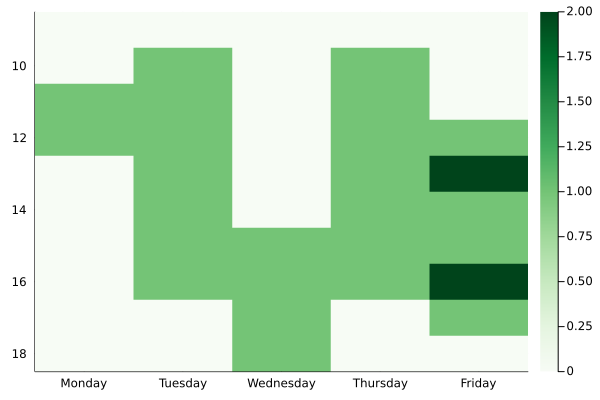

In [199]:
x_h = reshape([sum(x[i,j, 2] for i=1:ntot) for j=1:50], (10,5))
heatmap(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], [9:18], x_h, yflip = true, c=:Greens_9, clim=(0,2))

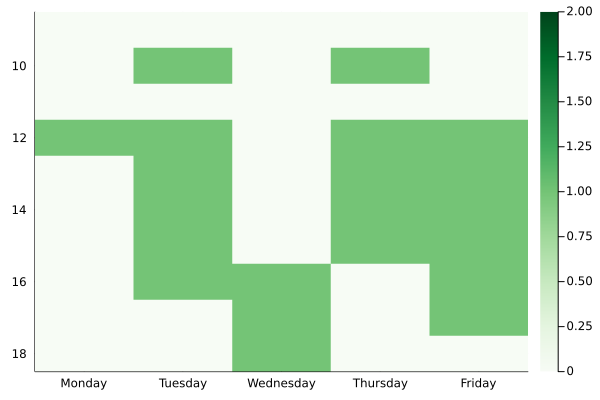

In [200]:
x_sh = reshape([sum(x[i,j, 2]*p_oracle[i,j] for i=1:ntot) for j=1:50], (10,5))
heatmap(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], [9:18], x_sh, yflip = true, c=:Greens_9, clim=(0,2))